## Monte Carlo Simulation for Scenario 2

In [37]:
import swolfpy as sp
import swolfpy_inputdata as spid
import swolfpy_processmodels as sppm

import brightway2 as bw2
import pandas as pd
import numpy as np
from time import time
import platform
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline

## SwolfPy version used to produced the results:

In [2]:
pd.DataFrame({'Version': [sp.__version__, sppm.__version__, spid.__version__]},
             index=['swolfpy', 'swolfpy_processmodels', 'swolfpy_inputdata'])

,Version
swolfpy,0.2.0
swolfpy_processmodels,0.1.4
swolfpy_inputdata,0.1.9


### System info

In [3]:
pd.DataFrame({'info': [platform.platform(),
                       platform.processor(),
                       os.cpu_count()]},
             index=['Platform', 'Processor', 'CPU_count'])

,info
Platform,Windows-10-10.0.18362-SP0
Processor,"Intel64 Family 6 Model 158 Stepping 9, GenuineIntel"
CPU_count,8


## Define project

In [4]:
project_name = 'MonteCarlo'
technosphere = sp.Technosphere(project_name)
common_data = spid.CommonData()
ProcessMetaData = sppm.ProcessModelsMetaData.ProcessModelsMetaData

In [5]:
# Treatment processes
Treatment_processes = {}
Treatment_processes['LF'] = {'input_type':ProcessMetaData['LF']['InputType'] , 'model':sppm.LF()}
Treatment_processes['Composting'] = {'input_type':ProcessMetaData['Comp']['InputType'] , 'model':sppm.Comp()}
Treatment_processes['AD'] = {'input_type':ProcessMetaData['AD']['InputType'] , 'model':sppm.AD()}
Treatment_processes['WTE'] = {'input_type':ProcessMetaData['WTE']['InputType'] , 'model':sppm.WTE()}
Treatment_processes['SS_MRF'] = {'input_type':ProcessMetaData['SS_MRF']['InputType'] , 'model':sppm.SS_MRF()}
Treatment_processes['Reprocessing'] = {'input_type':ProcessMetaData['Reproc']['InputType'] , 'model':sppm.Reproc()}

## Define Uncertainty (Treatement processes)

In [6]:
## Landfill
# Decay Rate
Treatment_processes['LF']['model'].InputData.LF_gas['actk']['uncertainty_type'] = 4
Treatment_processes['LF']['model'].InputData.LF_gas['actk']['loc'] = 0.04
Treatment_processes['LF']['model'].InputData.LF_gas['actk']['minimum'] = 0.02
Treatment_processes['LF']['model'].InputData.LF_gas['actk']['maximum'] = 0.17

# Initial gas collection efficiency
Treatment_processes['LF']['model'].InputData.LF_gas['initColEff']['uncertainty_type'] = 3
Treatment_processes['LF']['model'].InputData.LF_gas['initColEff']['loc'] = 50
Treatment_processes['LF']['model'].InputData.LF_gas['initColEff']['scale'] = 5

# Gas collection efficiency under intermediate cover
Treatment_processes['LF']['model'].InputData.LF_gas['intColEff']['uncertainty_type'] = 3
Treatment_processes['LF']['model'].InputData.LF_gas['intColEff']['loc'] = 75
Treatment_processes['LF']['model'].InputData.LF_gas['intColEff']['scale'] = 5

# Increased gas collection efficiency 
Treatment_processes['LF']['model'].InputData.LF_gas['incColEff']['uncertainty_type'] = 3
Treatment_processes['LF']['model'].InputData.LF_gas['incColEff']['loc'] = 82.5
Treatment_processes['LF']['model'].InputData.LF_gas['incColEff']['scale'] = 3

# Gas collection efficiency under final cover 
Treatment_processes['LF']['model'].InputData.LF_gas['finColEff']['uncertainty_type'] = 3
Treatment_processes['LF']['model'].InputData.LF_gas['finColEff']['loc'] = 90
Treatment_processes['LF']['model'].InputData.LF_gas['finColEff']['scale'] = 3

# Combustion efficiency for electricity production  
Treatment_processes['LF']['model'].InputData.LFG_Comb['convEff']['uncertainty_type'] = 3
Treatment_processes['LF']['model'].InputData.LFG_Comb['convEff']['loc'] = 0.365
Treatment_processes['LF']['model'].InputData.LFG_Comb['convEff']['scale'] = 0.03

In [7]:
# WTE
# Combustion efficiency for electricity production 
Treatment_processes['WTE']['model'].InputData.Elec_Prod_Eff['Gross_Efficiency']['uncertainty_type'] = 3
Treatment_processes['WTE']['model'].InputData.Elec_Prod_Eff['Gross_Efficiency']['loc'] = 0.27
Treatment_processes['WTE']['model'].InputData.Elec_Prod_Eff['Gross_Efficiency']['scale'] = 0.03

# Aluminum Recovery Rate from Bottom Ash (fraction)
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['uncertainty_type'] = 4
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['loc'] = 0.65
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['minimum'] = 0.4
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['maximum'] = 0.75

# Ferrous Recovery Rate from Bottom Ash (fraction)
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['uncertainty_type'] = 4
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['loc'] = 0.9
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['minimum'] = 0.7
Treatment_processes['WTE']['model'].InputData.Metals_Recovery['Al_Rec_Rate']['maximum'] = 0.95

In [8]:
# Reprocessing
# Electricity saving by reprocessing aluminum (kWh) 
Treatment_processes['Reprocessing']['model'].InputData.Al[('Technosphere', 'Electricity_production')]['uncertainty_type'] = 3
Treatment_processes['Reprocessing']['model'].InputData.Al[('Technosphere', 'Electricity_production')]['loc'] = 15343
Treatment_processes['Reprocessing']['model'].InputData.Al[('Technosphere', 'Electricity_production')]['scale'] = 500

# Electricity saving by reprocessing ferrous  (kWh) 
Treatment_processes['Reprocessing']['model'].InputData.Fe[('Technosphere', 'Electricity_production')]['uncertainty_type'] = 3
Treatment_processes['Reprocessing']['model'].InputData.Fe[('Technosphere', 'Electricity_production')]['loc'] = 894.08
Treatment_processes['Reprocessing']['model'].InputData.Fe[('Technosphere', 'Electricity_production')]['scale'] = 100

## Define Uncertainty (Collection)

In [9]:
# Distance
Processes = ['LF', 'Composting', 'AD', 'WTE', 'SS_MRF', 'Reprocessing', 'Collection']
data = sppm.Distance.create_distance_table(process_names=Processes,
                                           transport_modes=['Heavy Duty Truck'],
                                           default_dist=30)

distance = sppm.Distance(data)          
data['Heavy Duty Truck']

,LF,Composting,AD,WTE,SS_MRF,Reprocessing,Collection
LF,NaN,30.0,30.0,30.0,30.0,30.0,30.0
Composting,NaN,NaN,30.0,30.0,30.0,30.0,30.0
AD,NaN,NaN,NaN,30.0,30.0,30.0,30.0
WTE,NaN,NaN,NaN,NaN,30.0,30.0,30.0
SS_MRF,NaN,NaN,NaN,NaN,NaN,30.0,30.0
Reprocessing,NaN,NaN,NaN,NaN,NaN,NaN,30.0
Collection,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Collection_processes:
# Only include one single family sector wih residual waste collection
Collection_scheme = sppm.SF_Col.scheme()
Collection_scheme[('RWC', 'N/A', 'SSR')] = 1
Collection_processes = {}
Collection_processes['Collection'] = {'input_type': [],
                                      'model': sppm.SF_Col('Collection', Collection_scheme,
                                                      Treatment_processes=Treatment_processes,
                                                      Distance=distance)}

In [11]:
# Collection
# Residential Generation rate (kg/person-day) 
Collection_processes['Collection']['model'].InputData.Col['res_gen']['uncertainty_type'] = 3
Collection_processes['Collection']['model'].InputData.Col['res_gen']['loc'] = 2.05
Collection_processes['Collection']['model'].InputData.Col['res_gen']['scale'] = 0.05

## Write project

In [12]:
start = time()
demo = sp.Project(project_name, common_data, Treatment_processes, distance, Collection_processes, technosphere)
demo.init_project()
demo.write_project()
demo.group_exchanges()
print("Time for writing the project: {} second".format(round(time()-start)))

Biosphere database already present!!! No setup is needed
Vacuuming database 
Vacuuming database 


Writing activities to SQLite3 database:



                ####
                ++++++  Writing the Technosphere
                


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:12


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:00
  Finished: 07/01/2021 12:35:13
  Total time elapsed: 00:00:12
  CPU %: 47.20
  Memory %: 1.34


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 195.30
  Memory %: 1.35

              ####
              ++++++ Initializing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 104.20
  Memory %: 1.35


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.35

              ####
              ++++++ Initializing the WTE
              

Writing activities to SQLite3 database:


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.35

              ####
              ++++++ Initializing the SS_MRF
              


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 208.30
  Memory %: 1.35


Writing activities to SQLite3 database:



              ####
              ++++++ Initializing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 97.70
  Memory %: 1.35

              ####
              ++++++ Initializing the Collection
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:14
  Total time elapsed: 00:00:00
  CPU %: 100.80
  Memory %: 1.35


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the LF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:14
  Finished: 07/01/2021 12:35:15
  Total time elapsed: 00:00:00
  CPU %: 46.00
  Memory %: 1.37

                  ####
                  ++++++ Writing the Composting_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:16
  Finished: 07/01/2021 12:35:16
  Total time elapsed: 00:00:00
  CPU %: 99.70
  Memory %: 1.37

              ####
              ++++++ Writing the Composting
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:16
  Finished: 07/01/2021 12:35:16
  Total time elapsed: 00:00:00
  CPU %: 61.60
  Memory %: 1.37

                  ####
                  ++++++ Writing the AD_product
                  


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:16
  Finished: 07/01/2021 12:35:16
  Total time elapsed: 00:00:00
  CPU %: 66.50
  Memory %: 1.38


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the AD
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:16
  Finished: 07/01/2021 12:35:17
  Total time elapsed: 00:00:00
  CPU %: 53.90
  Memory %: 1.38

                  ####
                  ++++++ Writing the WTE_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:17
  Finished: 07/01/2021 12:35:17
  Total time elapsed: 00:00:00
  CPU %: 50.40
  Memory %: 1.39


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the WTE
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:17
  Finished: 07/01/2021 12:35:18
  Total time elapsed: 00:00:00
  CPU %: 47.00
  Memory %: 1.39

                  ####
                  ++++++ Writing the SS_MRF_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:18
  Finished: 07/01/2021 12:35:18
  Total time elapsed: 00:00:00
  CPU %: 57.10
  Memory %: 1.40


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the SS_MRF
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Writing activities to SQLite3 database:


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:19
  Finished: 07/01/2021 12:35:19
  Total time elapsed: 00:00:00
  CPU %: 54.50
  Memory %: 1.41

              ####
              ++++++ Writing the Reprocessing
              


0% [###############] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:19
  Finished: 07/01/2021 12:35:19
  Total time elapsed: 00:00:00
  CPU %: 60.10
  Memory %: 1.41

                  ####
                  ++++++ Writing the Collection_product
                  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:20
  Finished: 07/01/2021 12:35:20
  Total time elapsed: 00:00:00
  CPU %: 44.60
  Memory %: 1.41


Writing activities to SQLite3 database:



              ####
              ++++++ Writing the Collection
              


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 07/01/2021 12:35:21
  Finished: 07/01/2021 12:35:21
  Total time elapsed: 00:00:00
  CPU %: 62.50
  Memory %: 1.42

                  Grouping the exchanges with parameters in Database LF
                  

                  Grouping the exchanges with parameters in Database Composting
                  

                  Grouping the exchanges with parameters in Database AD
                  

                  Grouping the exchanges with parameters in Database WTE
                  

                  Grouping the exchanges with parameters in Database SS_MRF
                  

                  Grouping the exchanges with parameters in Database Reprocessing
                  

                  Grouping the exchanges with parameters in Database Collection
                  
Time for writing the project: 75 second


### Update parameters according to Scenario 2

In [13]:
new_param = [{'name': 'frac_of_Other_Residual_from_Composting_to_LF', 'amount': 0},
             {'name': 'frac_of_Other_Residual_from_Composting_to_WTE', 'amount': 1},
             {'name': 'frac_of_Other_Residual_from_AD_to_LF', 'amount': 0},
             {'name': 'frac_of_Other_Residual_from_AD_to_WTE', 'amount': 1},
             {'name': 'frac_of_Other_Residual_from_SS_MRF_to_LF', 'amount': 0},
             {'name': 'frac_of_Other_Residual_from_SS_MRF_to_WTE', 'amount': 1},
             {'name': 'frac_of_RWC_from_Collection_to_LF', 'amount': 0},
             {'name': 'frac_of_RWC_from_Collection_to_WTE', 'amount': 1},
             {'name': 'frac_of_SSO_from_Collection_to_Composting', 'amount': 0},
             {'name': 'frac_of_SSO_from_Collection_to_AD', 'amount': 1},
             {'name': 'frac_of_MRDO_from_Collection_to_LF', 'amount': 0},
             {'name': 'frac_of_MRDO_from_Collection_to_WTE', 'amount': 1}]

In [14]:
start = time()
demo.update_parameters(new_param)
print("Time for updating the parameters: {} second".format(round(time()-start)))

Time for updating the parameters: 9 second


### Create scenario

In [15]:
input_dict = {'Collection':{}}

for key in common_data.Index:
    input_dict['Collection'][key]=1
demo.create_scenario(input_dict,'Collection')

### Default results for Scenario 2

In [16]:
results = pd.DataFrame(columns=['Value', 'Unit'],
                       index=['Diversion','GWP','Operation Cost','Capital cost','Total cost',
                              'Collection','LF','WTE','Composting','AD','SS_MRF','Reprocessing'])

bw2.projects.set_current(project_name)
Demand = {('waste', 'Collection'):1}
FU=bw2.get_activity(('waste', 'Collection'))
method = ('IPCC 2013', 'climate change', 'GWP 100a')
lca=bw2.LCA(Demand,method)
lca.lci()
lca.lcia()
results.loc['GWP',:] = [round(lca.score/float(FU.as_dict()['unit'].split(' ')[0]),2), 'kg CO2/Mg']

lca.switch_method(('SwolfPy_Operational_Cost', 'SwolfPy'))
lca.lcia()
results.loc['Operation Cost',:] = [round(lca.score/float(FU.as_dict()['unit'].split(' ')[0]),2), '$/Mg']


lca.switch_method(('SwolfPy_Capital_Cost', 'SwolfPy'))
lca.lcia()
results.loc['Capital cost',:] = [round(lca.score/float(FU.as_dict()['unit'].split(' ')[0]),2), '$/Mg']

lca.switch_method(('SwolfPy_Total_Cost', 'SwolfPy'))
lca.lcia()
results.loc['Total cost',:] = [round(lca.score/float(FU.as_dict()['unit'].split(' ')[0]),2), '$/Mg']

for process in ['Collection','LF','WTE','Composting','AD','SS_MRF','Reprocessing']:
    results.loc[process,:] = [round(sp.LCA_matrix.LCA_matrix.get_mass_flow(lca, process)), 'Mg/yr']

results.loc['Diversion',:] = [round((1-results['Value']['LF']/results['Value']['Collection'])*100,2), '%']
results

,Value,Unit
Diversion,87.32,%
GWP,-574.17,kg CO2/Mg
Operation Cost,15.57,$/Mg
Capital cost,35.28,$/Mg
Total cost,50.86,$/Mg
Collection,74621,Mg/yr
LF,9460,Mg/yr
WTE,58759,Mg/yr
Composting,0,Mg/yr
AD,0,Mg/yr


## Monte Carlo simulation

In [17]:
process_models = []
process_model_names = []

for P in demo.Treatment_processes:
    process_models.append(demo.Treatment_processes[P]['model'])
    process_model_names.append(P)
    

mc = sp.Monte_Carlo(functional_unit=Demand,
                    method=[method],
                    project=demo.project_name,
                    process_models=process_models,
                    process_model_names= process_model_names,
                    seed=0)                    

In [18]:
mc.run(os.cpu_count(), 10000)

In [3]:
mc_results=mc.result_to_DF()
mc_results.to_pickle('MC_results.pickle')
#mc_results = pd.read_pickle('MC_results.pickle')
mc_results.head()

,"(IPCC 2013, climate change, GWP 100a)","(LF, Landfill Gas Parameters, actk)","(LF, Landfill Gas Parameters, initColEff)","(LF, Landfill Gas Parameters, intColEff)","(LF, Landfill Gas Parameters, incColEff)","(LF, Landfill Gas Parameters, finColEff)","(LF, LFG combustion, convEff)","(WTE, Elec_Prod_Eff, Gross_Efficiency)","(WTE, Metals_Recovery, Al_Rec_Rate)","(Reproc, Al, (Technosphere, Electricity_production))","(Reproc, Fe, (Technosphere, Electricity_production))","(Collection, SF_Collection, res_gen)"
0,-5.217797e+07,0.085638,54.893690,77.000786,88.102674,96.722680,0.417922,0.323659,0.772726,15563.613743,860.992985,2.034411
1,-4.857146e+07,0.158839,47.470617,81.330593,85.742436,97.635602,0.335682,0.283095,0.827707,16558.385594,868.870787,2.086450
2,-4.313855e+07,0.041503,57.470395,76.668372,83.439203,89.384525,0.378316,0.261678,0.712867,15397.804921,1052.328112,2.060891
3,-4.170034e+07,0.136135,53.402836,75.167195,80.799907,85.309510,0.339377,0.259357,0.810202,14888.383798,834.916334,2.005045
4,-4.235905e+07,0.161562,50.228793,67.728172,87.098338,89.438448,0.433093,0.268685,0.862286,15436.801613,861.093004,1.925661


<AxesSubplot:>

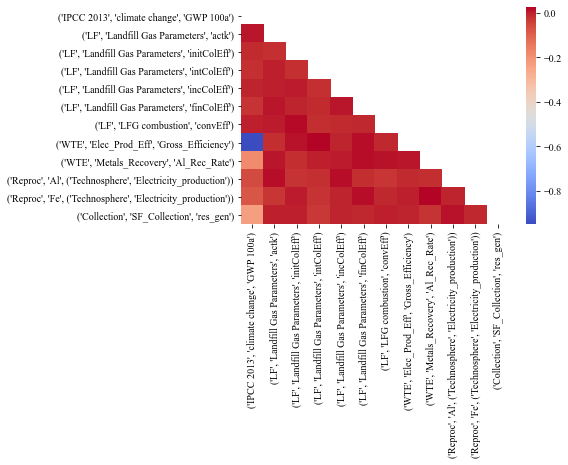

In [9]:
corr = mc_results.corr(method='pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,mask=mask,cmap='coolwarm')

In [11]:
index=list(mc_results.columns)
for x in [method]:
    index.remove(x)
A=corr.loc[index, [('IPCC 2013', 'climate change', 'GWP 100a')]]
A.sort_values(by=('IPCC 2013', 'climate change', 'GWP 100a'), key=lambda col: abs(col), ascending=False, inplace=True)
AA = A.loc[A.index[0:8],[('IPCC 2013', 'climate change', 'GWP 100a')]]
AA.to_csv('MC_Correlation_RawData.csv')

c:\users\msardar2\.conda\envs\dev\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



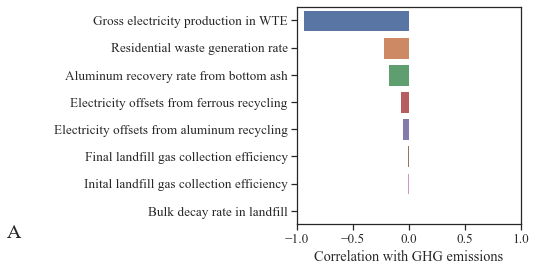

In [59]:
fig, ax= plt.subplots(figsize=(4,4))
sns.set(style = 'white',font_scale = 1.2, rc={'font.family':'serif', 'font.serif':'Times New Roman'})
sns.barplot(data=AA, x=('IPCC 2013', 'climate change', 'GWP 100a'),
            y=[str(i).replace("'",'') for i in AA.index], ax=ax)
ax.set_xlim((-1,1))
ax.set_xlabel(r"Correlation with GHG emissions")
ax.text(-3.6,8,'A', fontsize=20)

y_tick_lables = ax.set_yticklabels([
    'Gross electricity production in WTE',
    'Residential waste generation rate',
    'Aluminum recovery rate from bottom ash',
    'Electricity offsets from ferrous recycling',
    'Electricity offsets from aluminum recycling',
    'Final landfill gas collection efficiency',
    'Inital landfill gas collection efficiency',
    'Bulk decay rate in landfill'])

ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

fig.savefig('MC_Correlation',dpi=600, bbox_inches='tight')

In [15]:
bw2.projects.set_current('MonteCarlo')
FU = bw2.get_activity(('waste', 'Collection'))

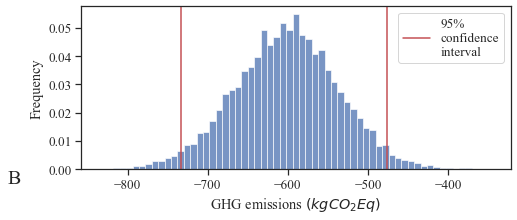

In [49]:
fig, ax = plt.subplots(figsize=(7.7,3))

histdata = mc_results[[('IPCC 2013', 'climate change', 'GWP 100a')]]/float(FU.as_dict()['unit'].split(' ')[0])

sns.histplot(data=histdata, x=histdata.columns[0], ax=ax, stat='probability', )
ax.set_xlabel(r"GHG emissions $(kg CO_2 Eq)$")
ax.text(-950,-0.005,'B', fontsize=20)
ax.set_ylabel('Frequency')
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.axvline(stats.scoreatpercentile(histdata, 2.5), c='r', label='95%\nconfidence\ninterval')
ax.axvline(stats.scoreatpercentile(histdata, 97.5), c='r')
ax.legend()

fig.savefig('MC_Dist',dpi=600, bbox_inches='tight')

In [24]:
histdata.describe(percentiles=[0.025,0.975])

,"(IPCC 2013, climate change, GWP 100a)"
count,10000.000000
mean,-602.390136
std,64.948823
min,-833.696966
2.5%,-733.623359
50%,-601.406715
97.5%,-476.701924
max,-346.788232


## Performace test

In [25]:
Performance=pd.DataFrame(columns=['Number of processors','time'])
Nproc = np.arange(1, os.cpu_count()+1)
n = [x*600 for x in Nproc]
time_list = []

In [26]:
for i,j in zip(Nproc, n):
    start = time()
    mc.run(i, j)
    time_list.append(round((time()-start)/j*10000/60,2))

Performance['Number of processors']=Nproc
Performance['time']=time_list

In [27]:
Performance['Speedup'] = round(Performance['time'][0]/Performance['time'], 2)
Performance['Efficiency'] = round(Performance['Speedup'] / Performance['Number of processors'] * 100)
Performance.to_csv('Performance_raw_data.csv')
Performance

,Number of processors,time,Speedup,Efficiency
0,1,67.37,1.00,100.0
1,2,34.70,1.94,97.0
2,3,24.22,2.78,93.0
3,4,21.09,3.19,80.0
4,5,19.15,3.52,70.0
5,6,17.86,3.77,63.0
6,7,16.59,4.06,58.0
7,8,15.98,4.22,53.0


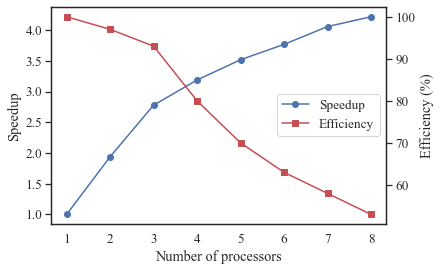

In [28]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(Performance['Number of processors'],Performance['Speedup'], label='Speedup',color='b', marker='o')
ax2 = plt.twinx()
ax2.plot(Performance['Number of processors'],Performance['Efficiency'], label='Efficiency', color='r', marker='s')

ax.set_xlabel('Number of processors')
ax.set_ylabel('Speedup')
ax2.set_ylabel('Efficiency (%)')

fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.6))

In [29]:
fig.savefig('Performance', dpi=600, bbox_inches='tight')